# AEFIT

This would be the first attempt to run the unsupervised learning VAE network to learn how to characterize a 1D profile with atted noise and missing input.


In [1]:
import numpy as np
import tensorflow as tf

# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 

import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt

#%aimport Dummy_g1data
#import Dummy_g1data as dummy
%aimport Dummy_dsx3
import Dummy_dsx3 as dummy

%aimport models.base
%aimport models.AEFIT
# ipysh.Bootstrap_support.debug()

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


## Data and Model
The model and data generator are set:
Dummy data generator generates from a set of 5 kind of curves with a dataset cardinality of 10K samples.

All the shapes are generated from a dictionary array that defines mean sigma and gain of sum of gaussians.
This table is printed from the variable ds.kinds

>NOTE: 
> The actual model is generating random so it is not redoing the very same samples on each epoch.
> To exactly constraint the maximum size of the dataset the buffer can be used

the model uses by default an input of 40 samples that are the (x,y) tuple values of 20 points from the generated shapes.
If the command **buffer()** is used all shaped are stored in a buffer and the generator yields always the same set of curves.


In [2]:
#ds = dummy.Dummy_g1data(counts=10000, size=20)
ds = dummy.Dummy_dsx3(counts=10000, size=20)

#ds.kinds=ds.kinds[:2]
#ds.kinds

ds.buffer()

In [3]:
# convert dataset to a mirrror data-data suitable to be fed into VAE
dds = ds.ds_array.map(lambda xy,l: (xy,xy) )

In [4]:
# create a VAE model from AEFIT prototype
m3 = models.AEFIT.AEFIT(feature_dim=40,latent_dim=4, scale=0.5, #0.5, 
                        #beta=10**(-6),
                        beta=0,
                        geometry=[20,20,10])


AEFIT5 ready:


In [5]:
m3.latent_dim
m3.set_rlv_bypass()
# m3.gamma = 0.01

In [6]:
m3.beta.assign(1e-5)

h  = models.base.RecordMetrics()

fit = lambda: m3.fit(dds.skip(3000).batch(20, drop_remainder=True), validation_data=dds.take(3000).batch(100), epochs=39, shuffle=False, callbacks=[h])
# If interactive notebook
models.base.fn_thread(m3, fit).control_panel()

# If standard notebook
# fit()

Button(button_style='success', description='start', style=ButtonStyle())

Button(button_style='primary', description='watch', style=ButtonStyle())

Button(description='clear log', style=ButtonStyle())

Output()

In [ ]:
m3.beta.assign(1e-6)

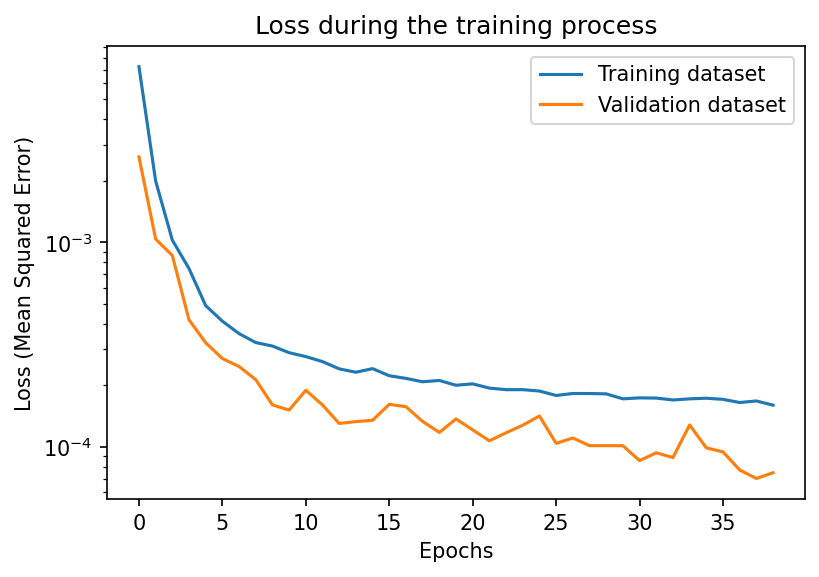

In [9]:
fig = plt.figure('mse')
fig.set_dpi(150)

plt.title('Loss during the training process')

plt.plot(h.metrics['loss'], label='Training dataset')
plt.plot(h.metrics['val_loss'], label='Validation dataset')

plt.ylabel('Loss (Mean Squared Error)')
plt.xlabel('Epochs')

plt.yscale("log")
plt.legend()
fig.savefig("DSX3_mse.pdf", bbox_inches='tight')

In [ ]:
# starts a viewer of the latentspace
p = Hplt.LSPlotBokeh()
p.set_model(m3)
p.set_data(ds, counts=1000)
p.plot(notebook_url='http://rat2.rfx.local:8888')

In [10]:
p = Hplt.LSPlotViolin()
p.set_model(m3)
p.set_data(ds, counts=1000)
p.plot(notebook_url='http://rat2.rfx.local:8888')

Loading BokehJS ...

-2.379989
-2.2106495
-0.075361714
-2.3771696


In [13]:
# this plot the relevance layer 
relevance = m3.generative_net.layers[0]
relevance.weights

[<tf.Variable 'aefi_t5_gRlv/kernel:0' shape=(4,) dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>]

## Missing data simulation

Now we want to test the network against particular shapes within the latent main paths but with added noise and simulated missing data. The function simulate_missing_data reduce de number of available input simply duplicating the point that precedes the missing one with the same value.

A further gaussian noise has been also applied.

In [ ]:

def simulate_missing_data(m, pt=[0.5,-1.6], noise_var=0.05, arr = []):
    xy = m.decode(tf.convert_to_tensor([pt]), training=False)
    x,y = tf.split(xy[0], 2)
    x,y = (x.numpy(), y.numpy())

    fig = plt.figure('gen_missing_curve',figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)    
    
    ax1.set_xlim(-2.,2.)
    ax1.set_ylim(-2.,2.)
    
    ax1.scatter(pt[0],pt[1],s=80)
    ax2.scatter(x,y,s=40)

    # apply noise
    x += np.random.normal(0,noise_var,len(x))
    y += np.random.normal(0,noise_var,len(y))

    # apply missing data simulation
    for i,v in enumerate(arr,0):
        x[arr[i]]=x[arr[i]+1]
        y[arr[i]]=y[arr[i]+1]
    
    ax2.scatter(x,y,s=80)

    me,va = m.encode(tf.reshape(tf.concat([x,y],0), shape=[1,-1]), training=False)
    print("Guessed Latent point = ",me.numpy())
    gpt = me[0].numpy()
    ax1.scatter(gpt[0],gpt[1])
    
    XY = m.decode(me, training=False)
    X,Y = tf.split(XY[0], 2)
    X,Y = (X.numpy(), Y.numpy())
    # plt.figure('reconstructed')
    ax2.scatter(X,Y,s=40)
    # plt.plot(X,Y)



We start by generating close to the shape {'mean': [0.5], 'sigma': [0.2], 'gain': [0.5]}

This is in the middle of the central cluster

In [ ]:
# generate from point: 0.6, -0.7
pt = [-0.400,0.593]
noise_var = 0.1
arr = [3,2,1,5,8,7,6,9,12,11,14,13,18]
simulate_missing_data(m3, pt,noise_var,arr)


Now we want to check if the nework can simulate a point in the middle od two clusters

In [ ]:
# generate from point: 0.5, -1.6
pt = [0.666,-0.278]
noise_var = 0.05
arr = [3,2,1,5,8,7,6,9,12,11,14,13,18]
simulate_missing_data(m3, pt,noise_var,arr)



In [ ]:
# generate from point: 0.5, -1.6
pt = [-1.283,0.541]
noise_var = 0.0
#arr = [3,2,1,5,8,7,6,9,12,11,14,13,18]
simulate_missing_data(m3, pt,noise_var)



# Reconstruction

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook

import ipysh

%aimport models.base

import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH
%aimport models.AEFIT5
%aimport models.Compose
%aimport models.GAN3

# import livelossplot.keras

Hunch models imported
reload set for module  Hunch_utils
reload set for module  Dummy_g1data
reload set for module  Hunch_lsplot
reload set for module  Hunch_tSNEplot


### Gaussian generation

Either for the Gaussian or Te profiles, we will generate 20 curves with the parameter charaterizing the abscisse of the main peak gradually increasing, so that we can see the effect on the missing points (that have always the same abscisses) on a peak vs not on a peak, because we assume this is where it's the most difficult to recover missing point for the VAE

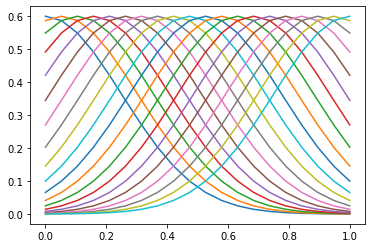

In [14]:
x = np.linspace(0,1,20)

def gauss(x, m, s=0.25, g=0.6):
    return np.abs(np.exp(-np.power(x-m, 2.) / (2 * np.power(s, 2.))) * g ) # + np.random.normal(0,self._noise,1))

mean_list = np.linspace(0,1,20)
gauss_list = []

for i in mean_list:
    gauss_list.append(gauss(x,m=i))
    
for i in gauss_list:
    plt.plot(x,i)


### Te profiles generation

In [11]:
import random as rd


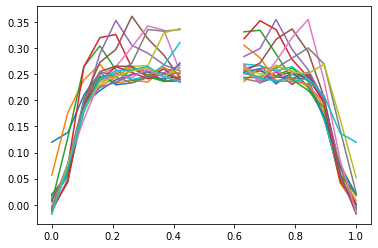

In [12]:
x = np.linspace(0,1,20)
import copy

def dsx3(x,a,b=80,c=200): # trying to match the real data but without physical meaning

    p = 12
    A = np.exp(-np.power(x-0.5, p) / (2 * np.power(0.41, p))) * c
    B = np.abs(np.exp(-np.power(x-a, 2.) / (2 * np.power(0.06, 2.))) * b)

    S = A*(A>0) + B*(B>0)

    # add error on points
    l=len(S)
    d=15
    for i in range(0,l):
        S[i]=S[i]+rd.randint(-d,d)
    
    
    # remove points (we don't do that now)
    # r = rd.randint(2,7)
    # for i in range(r):
    #     S[rd.randint(0,self._size-1)]=np.nan

    S=S/800
    return S

mean_list = np.linspace(0,1,20)
dsx3_list = []

for i in mean_list:
    dsx3_list.append(dsx3(x,a=i))
    
#for i in dsx3_list:
#    plt.plot(x,i)
    
dsx3_miss_list = copy.deepcopy(dsx3_list)

for i in range(0,20):
    dsx3_miss_list[i][9]=np.nan
    dsx3_miss_list[i][10]=np.nan
    dsx3_miss_list[i][11]=np.nan
    #dsx3_miss_list.append(dsx3_list[i])
    
for i in range(0,20):
    plt.plot(x,dsx3_miss_list[i])

x = np.linspace(0,1,20)

def dsx3_miss(x,a,b=80,c=200): # trying to match the real data but without physical meaning

    p = 12
    A = np.exp(-np.power(x-0.5, p) / (2 * np.power(0.41, p))) * c
    B = np.abs(np.exp(-np.power(x-a, 2.) / (2 * np.power(0.06, 2.))) * b)

    S = A*(A>0) + B*(B>0)

    # add error on points
    l=len(S)
    d=15
    for i in range(0,l):
        S[i]=S[i]+rd.randint(-d,d)
    
    S[9]=np.nan
    S[10]=np.nan
    S[11]=np.nan
    
    # remove points (we don't do that now)
    # r = rd.randint(2,7)
    # for i in range(r):
    #     S[rd.randint(0,self._size-1)]=np.nan

    S=S/800
    return S

mean_list = np.linspace(0,1,20)
dsx3_miss_list = []

for i in mean_list:
    dsx3_miss_list.append(dsx3_miss(x,a=i))
    
for i in dsx3_miss_list:
    plt.plot(x,i)

### Reconstruction

The model was trained with a mask on missing values to avoid learning missing points as a charasteristic, and therefore should be able to recover this missing points once the network is trained.
First we will randomly remove N (consecutive?) points from the curves, setting them to Nan values, and pass the curve to the trained VAE.
We need to plot : curve without missing data (line with lot x point AND the 20 points) + curve with the missing point + curve reconstructed 

In [13]:
print(xy[0][19])
a= np.float32(xy[0][19])
print(a)
xy[0][19]=np.nan

NameError: name 'xy' is not defined

In [14]:
dsx3_list[1]

array([ 0.056681  ,  0.15767985,  0.23886976,  0.24512168,  0.2587243 ,
        0.2350396 ,  0.25374819,  0.24749995,  0.23375   ,  0.2575    ,
        0.25375   ,  0.24375   ,  0.25499985,  0.26749154,  0.24107747,
        0.2505895 ,  0.23241073,  0.19830658,  0.04392985, -0.01388218])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



[0.00014553714957262764, 3.181424547525902e-05, 3.5050354286225714e-05, 1.6531141021280948e-05, 9.338465625742254e-05, 5.415181533684477e-05, 0.00013816956040586527, 0.00015337035632745355, 8.562929833861865e-05, 0.0004224606085612148, 0.00018590252214005786, 6.970672603398009e-05, 9.047607474337305e-05, 2.164510770314987e-05, 3.235597291172399e-05, 1.6368069481353942e-05, 6.31276000767178e-05, 0.0002466264876787805, 0.0004306842283707146, 0.00016288052601567404]
1.2e-4


/usr/local/anaconda/3/2020.01/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


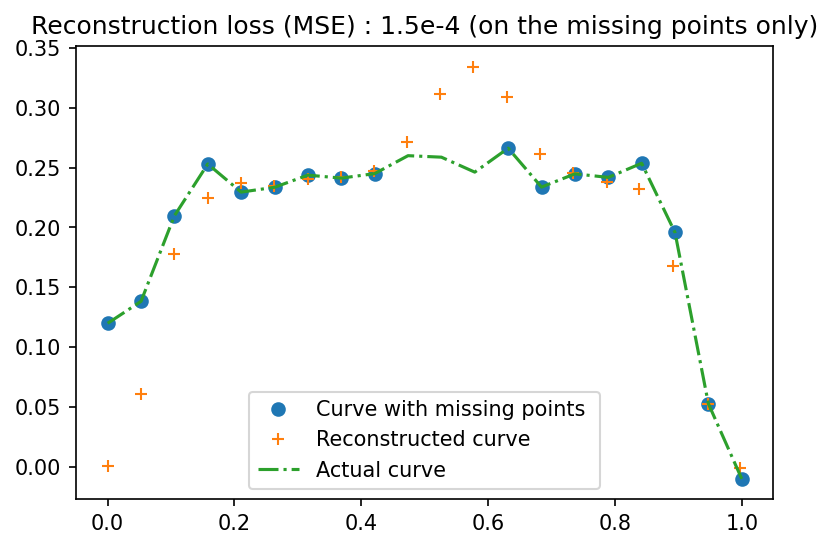

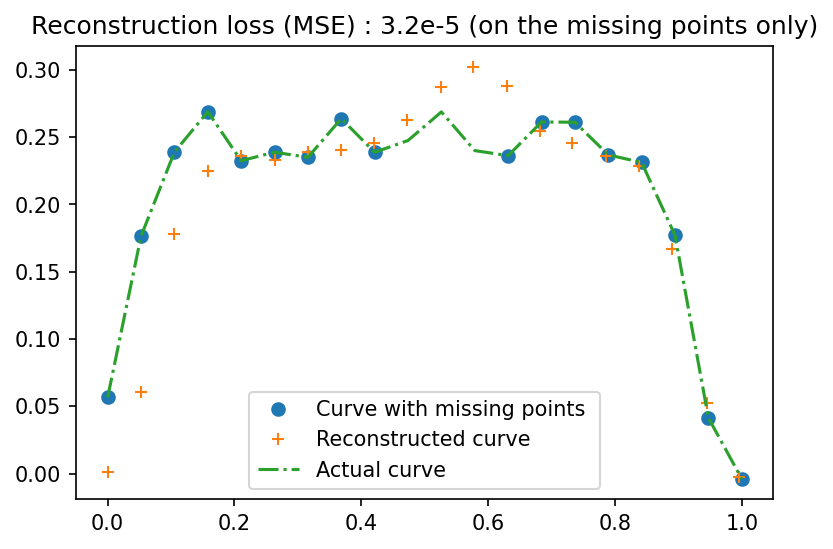

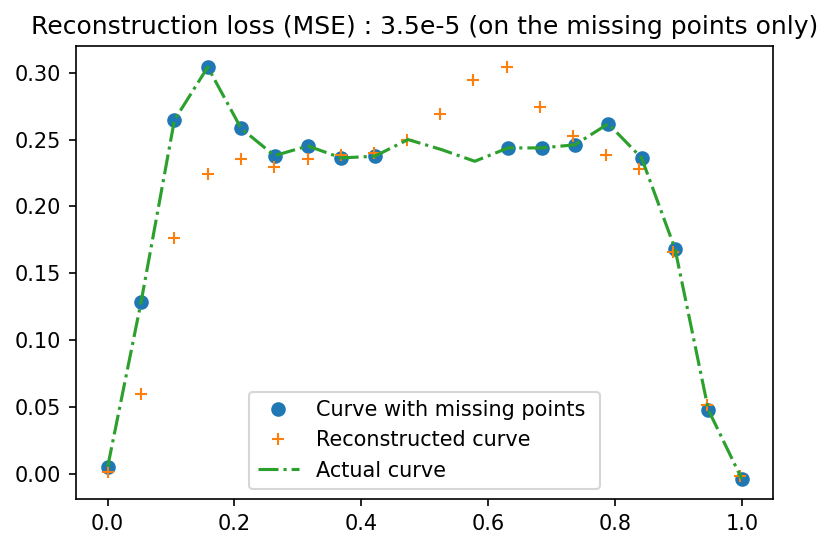

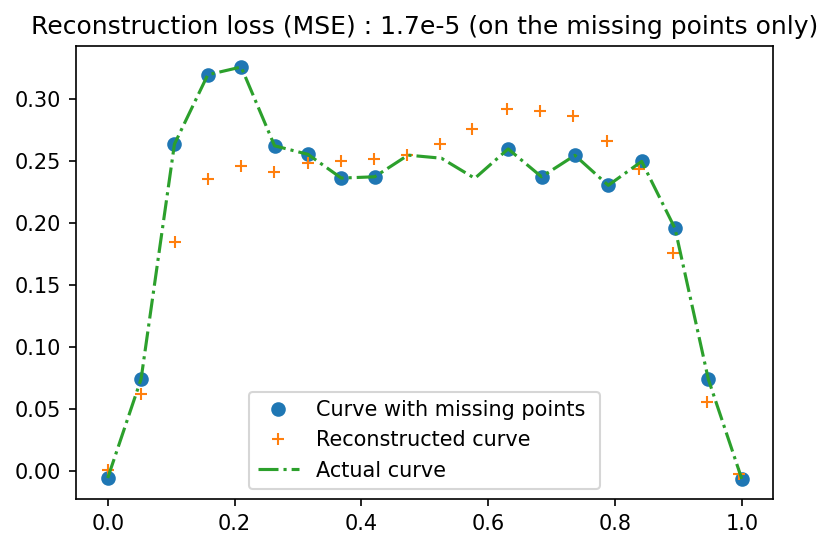

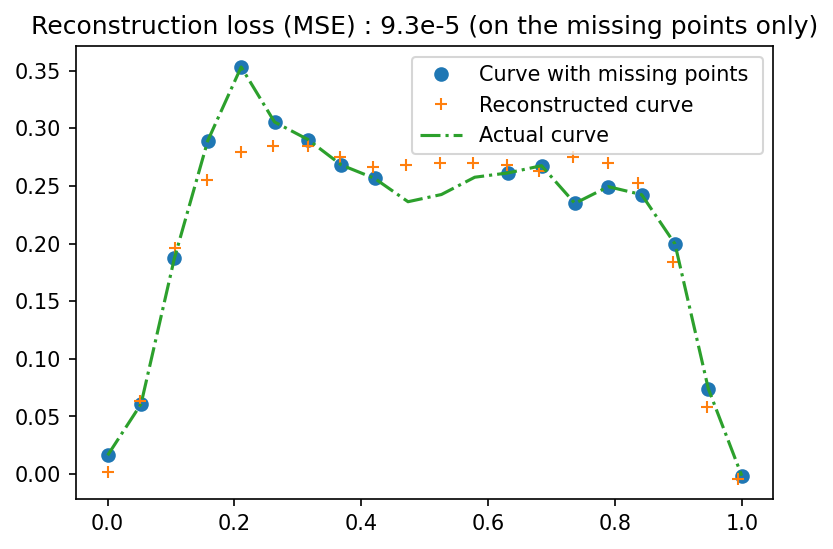

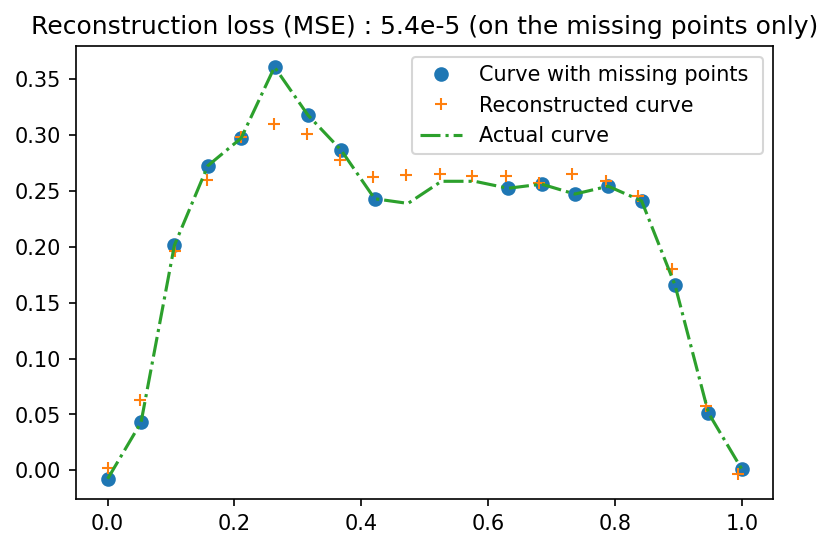

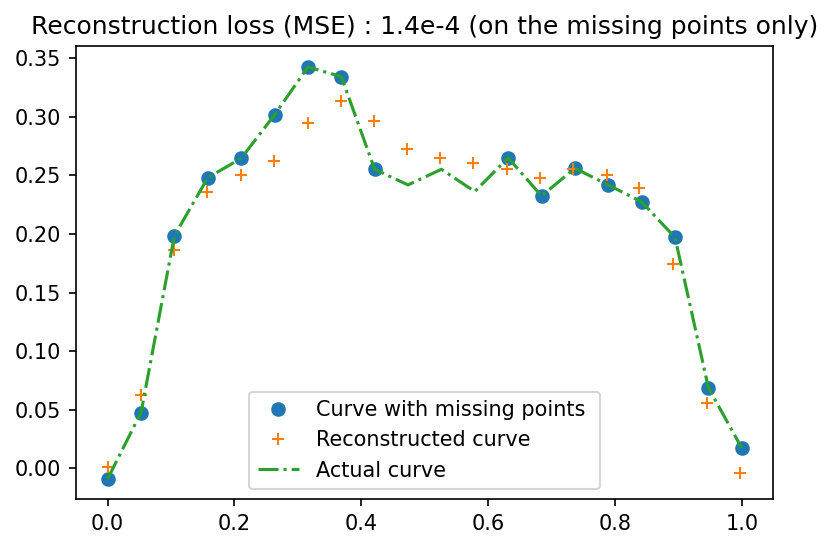

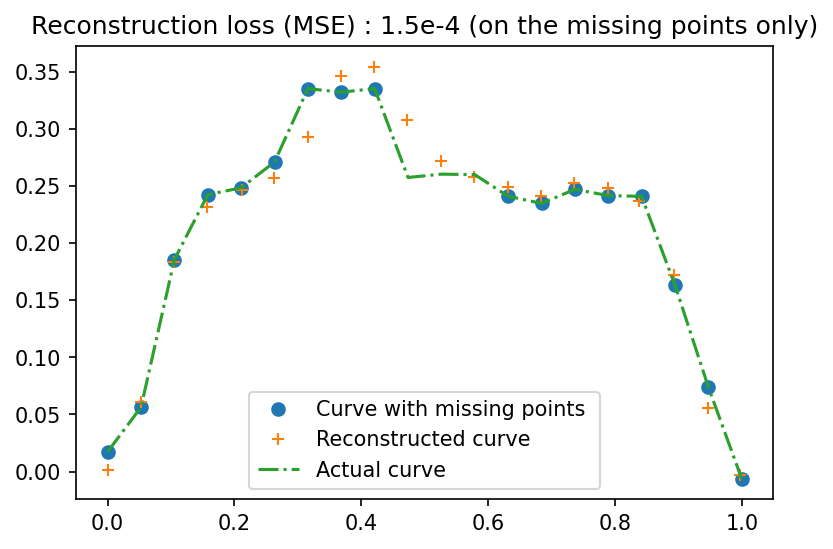

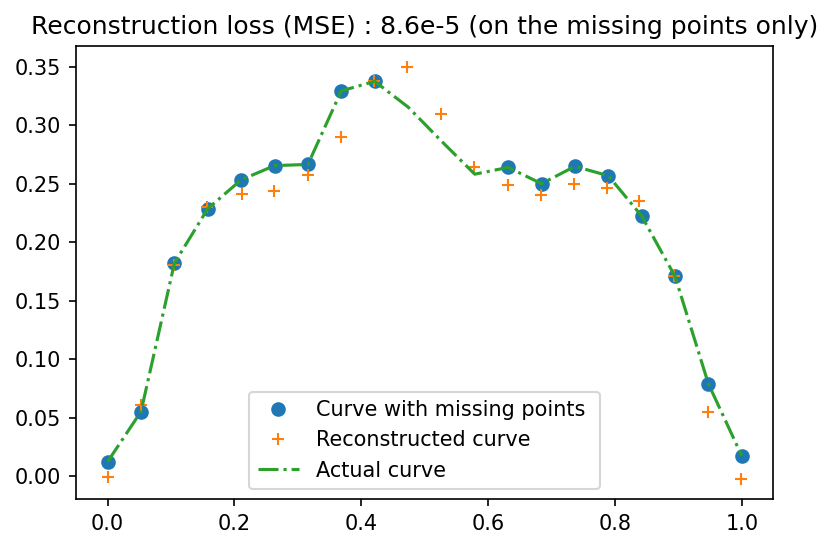

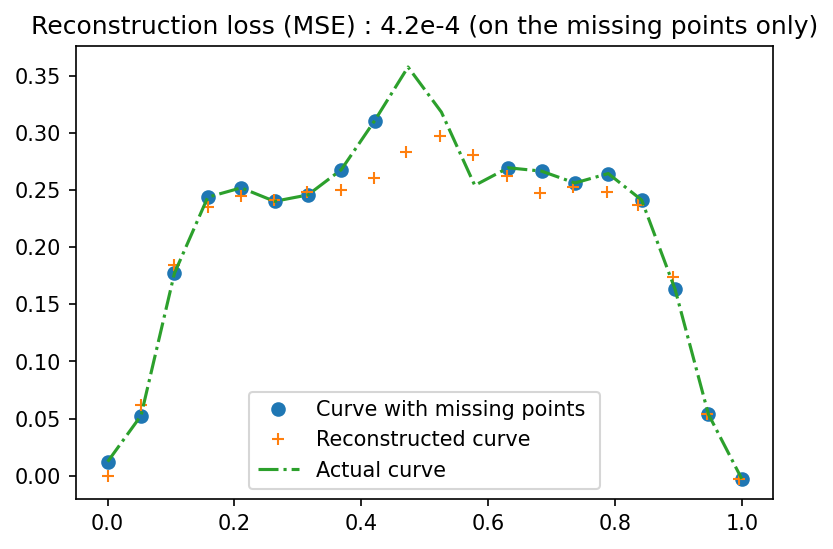

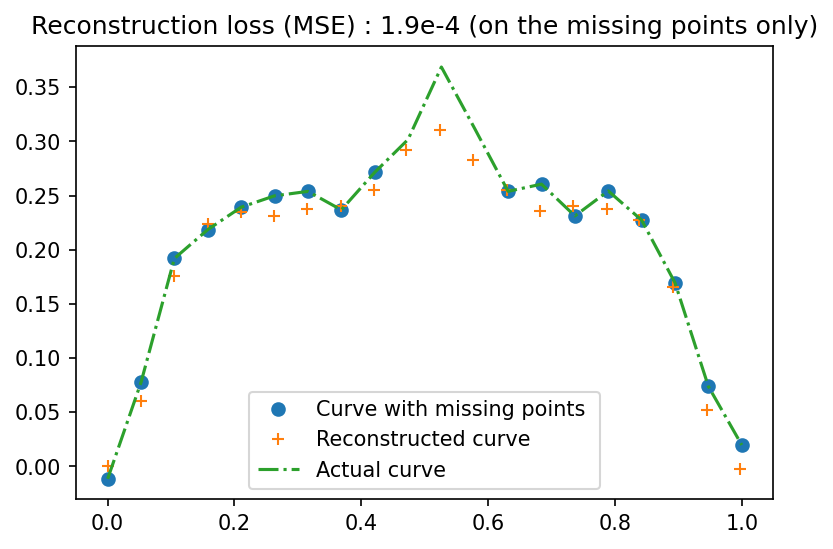

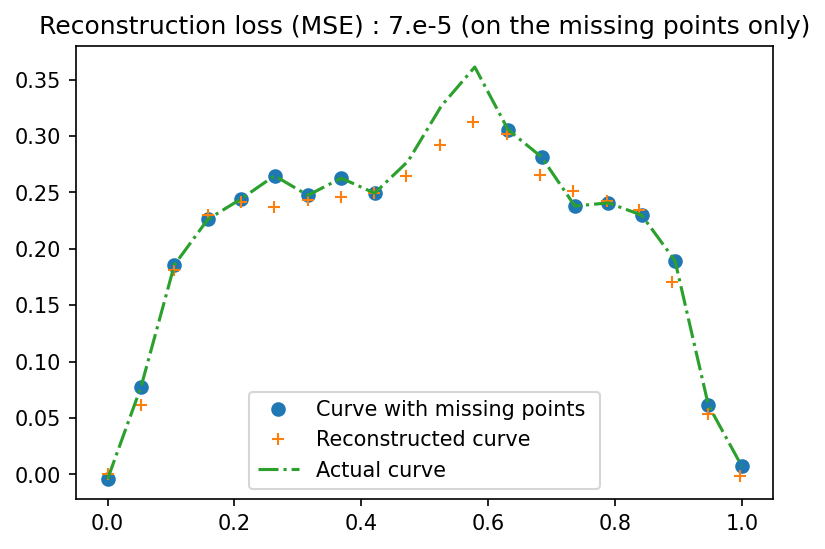

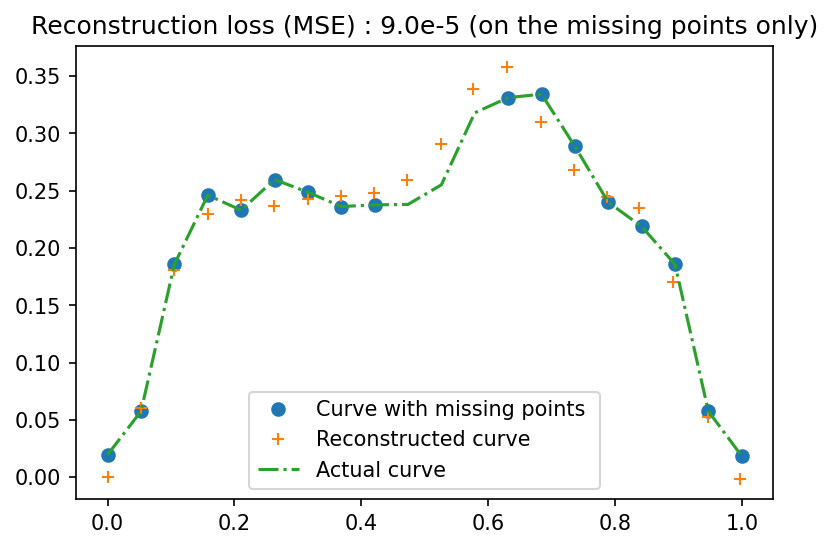

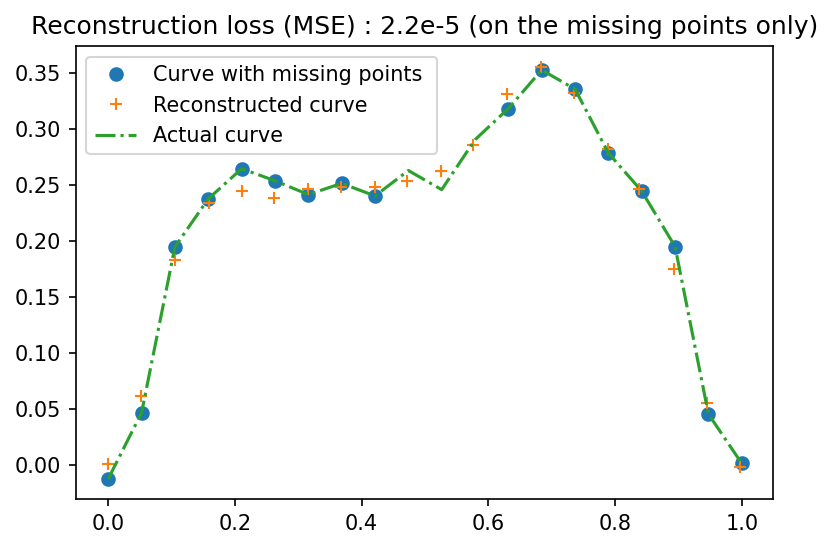

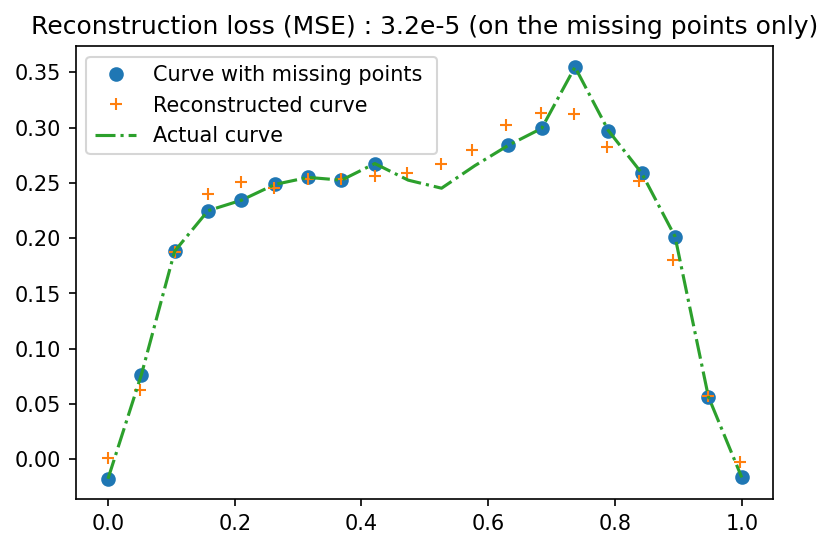

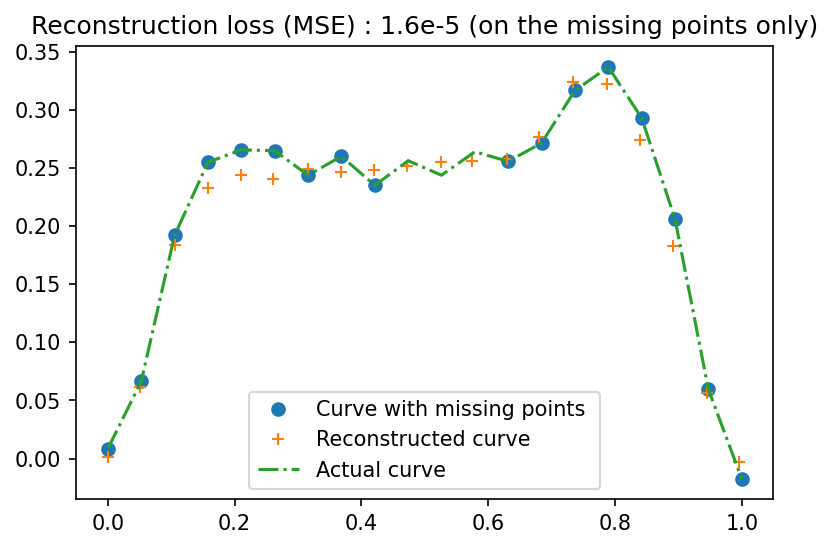

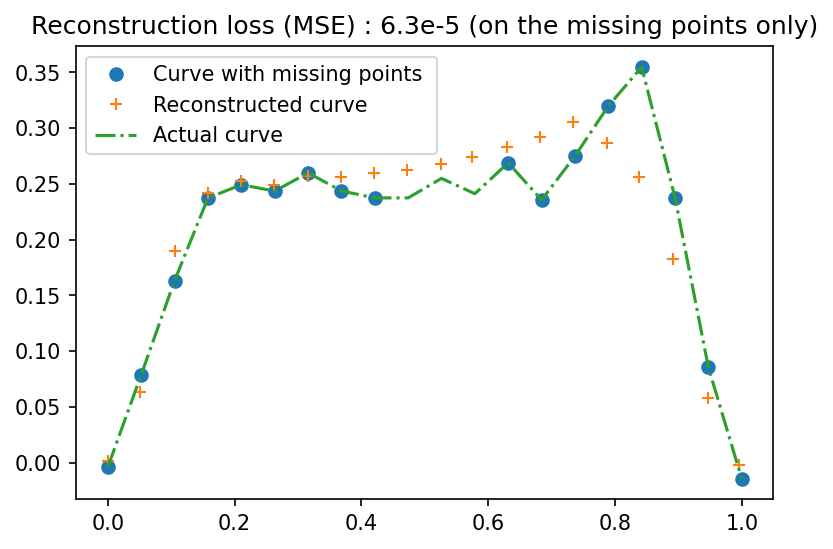

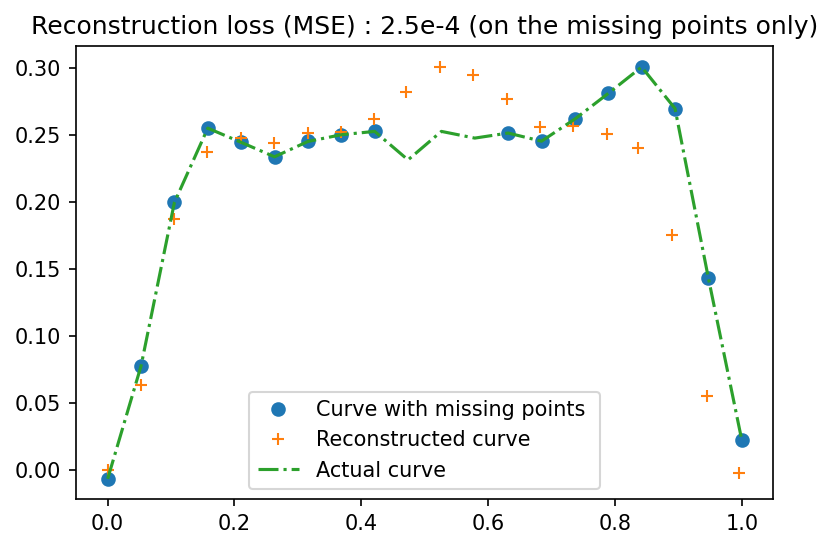

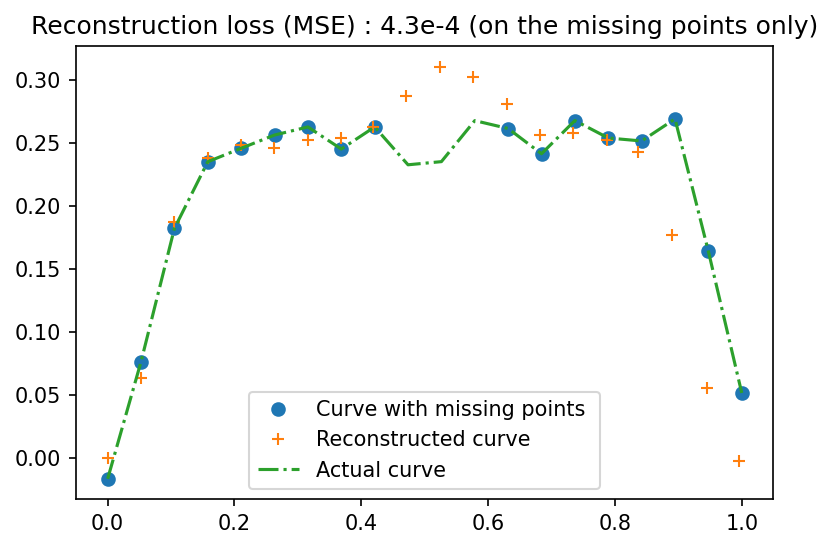

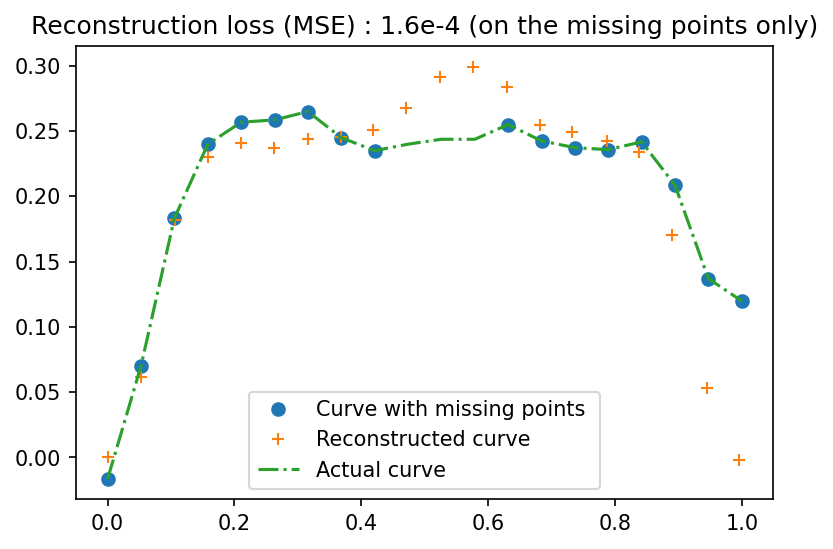

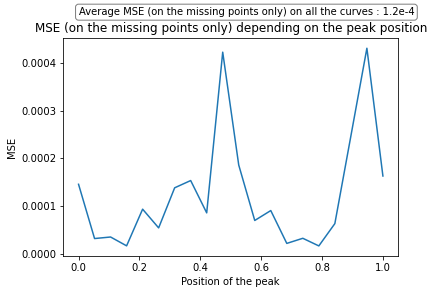

In [14]:

mse_list=[]
for j in range(20):
    y = dsx3_miss_list[j]
    ybis = dsx3_list[j]
    #y = gauss_list[j]

    xy = np.concatenate((x,y))
    xy = tf.convert_to_tensor([xy])

    xy_withoutmiss = np.concatenate((x,ybis))
    xy_withoutmiss = tf.convert_to_tensor([xy_withoutmiss])

    XY = m3(xy, training=False)
    #print(xy, XY)


    def mse_curve(input, output):
        mse=0
        for i in range(9,12):
            a=np.float32(input[0][19+i])
            b=np.float32(output[0][19+i])
            mse = mse + (a - b)**2
        mse=mse/20
        #mse_list.append(mse)
        return mse
    
    mse = mse_curve(xy_withoutmiss, XY)
    mse_list.append(mse)
    #print(mse)
    #print(mse_list)
        

    def plot_tf(xy, name=None, h='.'):
        fig = plt.figure(f'plot{j}')    
        fig.set_dpi(150)
        ax = plt.gca()    
        #ax.set_ylim(0.,0.5)
        xy = tf.reshape(xy, [-1])
        x,y = tf.split(xy, num_or_size_splits=2, axis=0)
        plt.plot(x,y,h, label=name)
        plt.title(f'Reconstruction loss (MSE) : {np.format_float_scientific(mse, precision = 1, exp_digits=1)} (on the missing points only)')
        ax.legend()
        fig.savefig(f"test_reco{j}.pdf", bbox_inches='tight')

    plot_tf(xy, 'Curve with missing points ','o')
    plot_tf(XY, 'Reconstructed curve','+')
    plot_tf(xy_withoutmiss,'Actual curve ','-.' )
    
print(mse_list)
av=0
for i in range(len(mse_list)):
    av=av + mse_list[i]
av=av/20
print(np.format_float_scientific(av, precision = 1, exp_digits=1))

fig_err = plt.figure()
plt.plot(mean_list,mse_list)
plt.ylabel("MSE")
plt.xlabel("Position of the peak")
plt.title("MSE (on the missing points only) depending on the peak position")
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.text(0,0.0005,f"Average MSE (on the missing points only) on all the curves : {np.format_float_scientific(av, precision = 1, exp_digits=1)}", bbox=props)
fig_err.savefig("dsx3_mse_peak_misspoints.pdf", bbox_inches='tight')

### 1) Overall Reconstruction Error

This is basically the error the VAE is trying to reduce during the training process

### 2) Missing points Reconstruction Error 

In [ ]:
print(pos)

d_pos = [x for x in ds.skip(pos).batch(1).take(1)][0]
path = '/home/andrea/Documents/phd/Thesis/img/STEP12/STEP12_7'


def plot_tf(xy, name=None, h='.'):
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,0.8)
    xy = tf.reshape(xy, [-1])
    x,y = tf.split(xy, num_or_size_splits=2, axis=0)
    plt.plot(x,y,h, label=name)
    ax.legend()

def plot(x,y, name=None, h='.'):  
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,0.8)
    plt.plot(x,y, h, label=name)
    #ax.legend()
    
def plot_bar_x(index, w, title, w2=None):
    # this is for plotting purpose
    fig = plt.figure(title)
    fig.set_dpi(150)
    plt.bar(index, w, color='lightgrey', edgecolor='black')    
    plt.ylabel('plasma parameters', fontsize=10)
    plt.xticks(index, fontsize=10)
    plt.title(title)
    return fig
    

p  = d_pos[0]
xy = d_pos[1]

fig = plt.figure('plot')
# plt.text(0.05,0.7, '$I_p = %.2f$'%qsh[pos]['Ip'] )
ax = plt.gca()
ax.set_title( 'Te reconstruction '+qsh[pos].label.decode("utf-8") )

XY_vae = vae(xy, training=False)
ls = gen(d_pos[0], training=False)
XY = vae.decode(ls, training=False)
# XY = tf.sigmoid(XY)
plot_tf(xy, '$T_e$','-.')
plot_tf(XY_vae, 'ls6','+')
plot_tf(XY, 'guess','x')
plot(qsh[pos]['prel'],qsh[pos]['te'], '$T_c$')

fig2 = plt.figure('contour')
ax2  = plt.gca()
fig2.set_dpi(150)
qsh[pos].plot_countour(ax=ax2)
#fig2.savefig( path+'/Contour_'+str(pos)+'.png')

fig3 = plot_bar_x(['Ip','NS','Vt','F'], qsh[pos]['Ip~NS~VT~F'], 'params')
#fig3.savefig( path+'/Params_'+str(pos)+'.png')

fig = plt.figure('plot')
#fig.savefig( path+'/Te_rec_'+str(pos)+'.png')

# fig = plt.figure('Flux')
# fig.savefig(path+'/Te_Flux_'+str(pos)+'.png')



pos += 1